In [283]:
import sqlite3
import csv
import pandas as pd

conn = sqlite3.connect('yelp.db')
c = conn.cursor()


### Look at the review data

In [ ]:
#a = pd.read_csv('data/review_subset.csv')

### Look at the business data

In [ ]:
#pd.read_csv('data/business_data2.csv')

In [ ]:
#pd.read_csv('data/income_zipcode.csv')

# Create database structure
1. include users, business, income, review fact table
2. star schema

In [275]:
def create_database(conn):
    c = conn.cursor()

    c.execute('''DROP TABLE IF EXISTS business''')
    c.execute('''DROP TABLE IF EXISTS users''')
    c.execute('''DROP TABLE IF EXISTS income''')
    c.execute('''DROP TABLE IF EXISTS states''')
    c.execute('''DROP TABLE IF EXISTS review_fact_table''')
    
    c.execute('''
            CREATE TABLE users(
                user_id VARCHAR PRIMARY KEY, 
                review_count int,
                yelping_since DATE,
                average_stars REAL,
                UNIQUE(user_id))''')
    
    c.execute('''
            CREATE TABLE business(
                b_id VARCHAR,
                categories text,
                city text,
                is_open int,
                latitude REAL,
                longitude REAL,
                name text,
                postal_code REAL,
                pricerange int,
                review_count int,
                b_stars REAL,
                state text,
                PRIMARY KEY(b_id)
                UNIQUE(b_id) )''')
    
    c.execute('''
            CREATE TABLE income(
                zipcode INTEGER PRIMARY KEY,
                county text,
                state text, 
                avg_income REAL)
                ''')
    

    
    #create fact_table
    c.execute('''
        CREATE TABLE review_fact_table(
            review_id VARCHAR,
            user_id VARCHAR,
            business_id VARCHAR,
            zipcode int,
            review text,
            r_stars REAL,
            r_date DATE,
            PRIMARY KEY (review_id),
            FOREIGN KEY (user_id) REFERENCES users(user_id), 
            FOREIGN KEY (zipcode) REFERENCES income(zipcode),
            FOREIGN KEY (business_id) REFERENCES business(b_id))''')
    # Commit changes
    conn.commit()
# Create the database   
create_database(conn)

# Populate database
1. Users table from user_data.csv
2. Business table from business_data.csv
3. income table from income_data.csv
4. review_fact_table table from review_data2.csv 


In [276]:
def populate_database(conn):    
    #reader = csv.reader(open('review_data2.csv', encoding='latin1'))
    reader = csv.reader(open('data/business_data2.csv', encoding='latin1'))

    
    income_dict = {}
    income_id = 0
    
    next(reader, None)
    for row in reader:
        r = row[0]
        row = [item.lower() for item in row[1:]]   
        # business table
        try:
            c.execute('''
                INSERT INTO business(b_id,
                                    categories,
                                    city,
                                    is_open,
                                    latitude,
                                    longitude,
                                    name,
                                    postal_code,
                                    pricerange,
                                    review_count,
                                    b_stars,
                                    state)VALUES(?,?,?,?,?,?,?,?,?,?,?,?)''',
                      (r,row[0],row[1], row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10]))
        except sqlite3.Error as e:
            print("business, insert error:", e.args[0])
    conn.commit()
              
   



    # Income table    
    reader = csv.reader(open('data/income_zipcode.csv', encoding='latin1'))
    next(reader, None)
    for row in reader:
        row = [item.lower() for item in row]
        # col 0 = zip_code, col 1 = state_x, col 2 = county_x, col 3 = combine, col 4 = income
        try:
            c.execute('''
                INSERT INTO income(zipcode, county,state, avg_income)VALUES(?,?,?,?)
            ''',(row[0],row[2],row[1],row[4]))
        except sqlite3.Error as e:
            print("income, insert error:", e.args[0])
    conn.commit()
    
    
    
    
    
     # user table : col 0 = average_stars, col 1 = review_count, col 2 = user_id, col 3 = yelping_since   
    reader = csv.reader(open('data/user_data.csv', encoding='latin1'))
    next(reader, None)
    for row in reader:
        #row = [item.lower() for item in row]
        try:
            c.execute('''
                INSERT INTO users(user_id, review_count, yelping_since, average_stars)VALUES(?,?,?,?)
                ''', (row[2], row[1], row[3], row[0]))
        except sqlite3.Error as e:
            print("users, insert error:", e.args[0])
    conn.commit()
                      
                      
                                         
                      
    # review fact table
    # 0 business_id
    # 1 date
    # 2 review_id
    # 3 stars
    # 4 text
    # 5 user_id
    
    # col 0 = business_id, col 1 = date, col 2 = review_id, col 3  = stars
    # col 4 = text, col 5 = user_id
    reader2 = csv.reader(open('data/review_subset.csv', encoding='latin1'))
    next(reader2, None)
    for row in reader2:
        row[4] = row[4].lower()   
            # review table    
        try:
            c.execute('''
                INSERT INTO review_fact_table (review_id, 
                                                user_id, 
                                                business_id,
                                                zipcode,
                                                review, 
                                                r_stars, 
                                                r_date)
                SELECT ?, ?, business.b_id, income.zipcode, ?,?,?
                FROM income, business
                WHERE income.zipcode = business.postal_code AND business.b_id = ? 
                ''', (row[2], row[5], row[4], row[3], row[1], row[0]))
            
        except sqlite3.Error as e:
            print("review_fact_table2, insert error:", e.args[0])
    conn.commit()                                      

In [277]:
# create_database(conn)
populate_database(conn)

In [ ]:
# for t in['business', 'income','users','review_fact_table']:
#     print('%s:'%t)
#     print(pandas.read_sql_query("SELECT * FROM %s"%t, conn), '\n')

# Initiate database & SQL

In [270]:
!pip install ipython-sql
%reload_ext sql
%sql sqlite:///yelp.db

'Connected: None@yelp.db'

# Try SQL

In [9]:
%%sql
SELECT count(r.review_id) FROM business 
JOIN review_fact_table r on r.business_id = business.b_id
where business.state = 'nv'

Done.


count(r.review_id)
772691


### VISUALIZATION

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Extract data for UI

In [ ]:
business_name_input = 'pei wei'
zipcode = '85374'

In [63]:
c.execute('''
        SELECT b_id,r.review, r.r_stars
        FROM business, review_fact_table r 
        WHERE postal_code = ? AND name = ? AND r.business_id = b_id''', (zipcode, business_name_input,))
dataframe = pd.DataFrame(data = c.fetchall(), columns = ['business_id', 'review','rating'])
#dataframe.plot.bar(x='actor_name', title='actor facebook likes', figsize=(10,7))

In [258]:
dataframe.head()

,business_id,review,rating
0,jqsnfozdpxpmourswcg1vq,"this place is horrible, we were so excited to ...",1.0
1,jqsnfozdpxpmourswcg1vq,"for being fairly ""fast"" food.. pei wei (pronou...",4.0
2,jqsnfozdpxpmourswcg1vq,"i decided to try it out, i'm celiac and theref...",5.0
3,jqsnfozdpxpmourswcg1vq,i'm not saying pei wei is the best asian food ...,3.0
4,jqsnfozdpxpmourswcg1vq,sometimes the food is spot on and delicious an...,3.0


### VISULIZATION 2: business by category in each state

count     int64
state    object
label    object
dtype: object


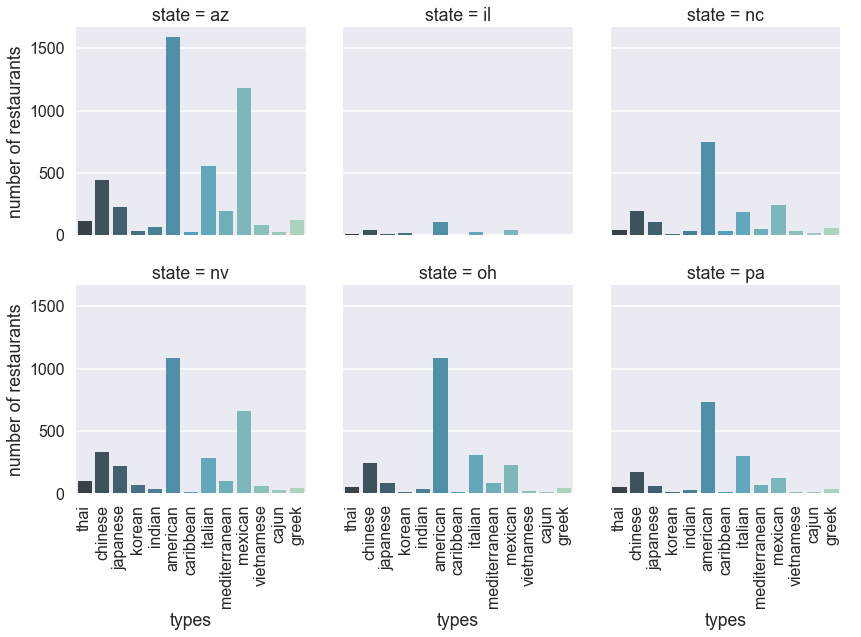

In [260]:
import seaborn as sns
def visual_category1():
    cat = ['thai','chinese','japanese','korean','indian','american','caribbean','italian','mediterranean',
      'mexican','vietnamese','cajun','greek']
    df_name = ['thai_df','chinese_df','japanese_df','korean_df','indian_df','american_df','caribbean_df',
           'italian_df','mediterranean_df','mexican_df','vietnamese_df','cajun_df','greek_df']
    df_name2 = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
    
    for i, key in enumerate(cat):
    
        string = '''SELECT COUNT(b_id), state FROM business WHERE categories LIKE '%{}%' GROUP BY state'''.format(key)
        #print(string)
        c.execute(string)
        df_name[i] = pd.DataFrame(data = c.fetchall(), columns = ['count','state'])
        d = {'label': [key]*6}
        df_name2[i] = pd.DataFrame(data=d)
        df_name[i] = pd.concat([df_name[i],df_name2[i]], axis = 1)


    nationality_df = pd.concat([df_name[0],df_name[1],df_name[2],df_name[3],df_name[4],df_name[5],df_name[6],
                            df_name[7],df_name[8],df_name[9]], axis = 0)
    nationality_df = pd.concat([nationality_df,df_name[10],df_name[11],df_name[12]], axis = 0)
    return nationality_df

nationality_df = visual_category1()
print(nationality_df.dtypes)
################### Visulization #####################################################

sns.set_style("darkgrid", {'axes.grid': True})
sns.set_context("poster")


g = sns.FacetGrid(nationality_df, col='state', col_wrap=3,margin_titles=True, size=4)
g.map(sns.barplot,'label','count',palette="GnBu_d")
g.add_legend()
g.set_xticklabels(rotation=90)


# Modify the details of the matplotlib Axes g
#g.despine(left=True)
g.set_ylabels('number of restaurants')
g.set_xlabels('types')

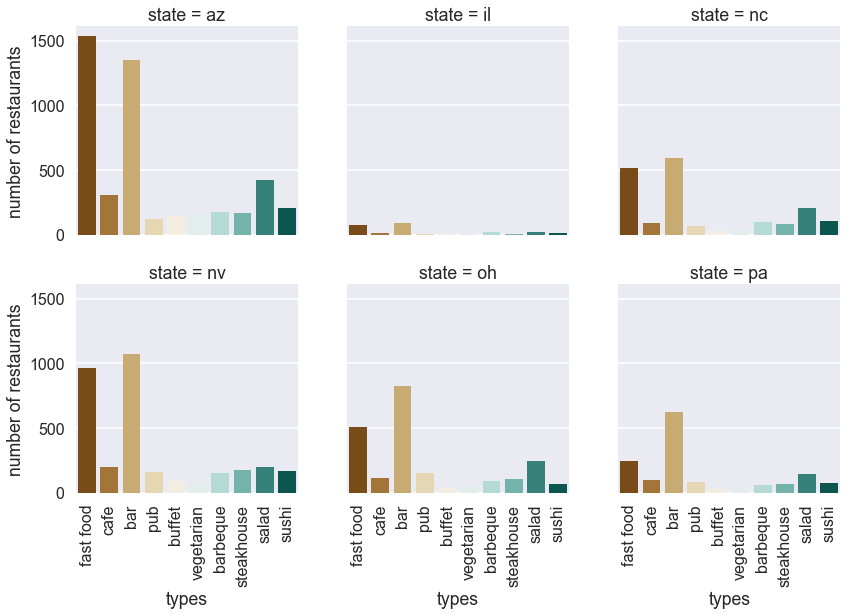

In [262]:
################Visulization ##################
def visual_category2():
    cat = ['fast food', 'cafe','bar','pub','buffet', 'vegetarian', 'barbeque','steakhouse','salad', 'sushi']
    df_name = ['fast food_df', 'cafe_df','bar_df','pub_df',
               'buffet_df', 'vegetarian_df', 'barbeque_df','steakhouse_df','salad_df', 'sushi_df']
    df_name2 = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
    for i, key in enumerate(cat):
        string = '''SELECT COUNT(b_id), state FROM business WHERE categories LIKE '%{}%' GROUP BY state'''.format(key)
        #print(string)
        c.execute(string)
        df_name[i] = pd.DataFrame(data = c.fetchall(), columns = ['count','state'])
        d = {'label': [key]*6}
        df_name2[i] = pd.DataFrame(data=d)
        df_name[i] = pd.concat([df_name[i],df_name2[i]], axis = 1)


    type_df = pd.concat([df_name[0],df_name[1],df_name[2],df_name[3],df_name[4],df_name[5],df_name[6],
                            df_name[7],df_name[8],df_name[9]], axis = 0)
    return type_df

result = visual_category2()
#print(result)
sns.set_style("darkgrid", {'axes.grid': True})
sns.set_context("poster")


g = sns.FacetGrid(result, col='state', col_wrap=3,margin_titles=True, size=4)
g.map(sns.barplot,'label','count',palette="BrBG")
g.add_legend()
g.set_xticklabels(rotation=90)


# Modify the details of the matplotlib Axes g
#g.despine(left=True)
g.set_ylabels('number of restaurants')
g.set_xlabels('types')

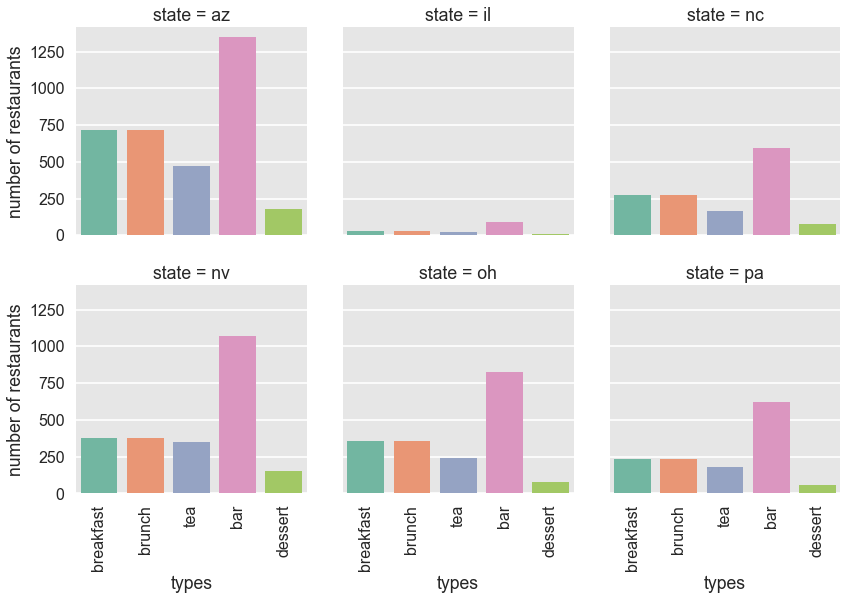

In [263]:
################Visulization ##################
def visual_category3():
    cat = ['breakfast','brunch','tea','bar','dessert']
    df_name = ['breakfast_df','brunch_df','tea_df','bar_df','dessert_df']
    df_name2 = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
    for i, key in enumerate(cat):
        string = '''SELECT COUNT(b_id), state FROM business WHERE categories LIKE '%{}%' GROUP BY state'''.format(key)
        #print(string)
        c.execute(string)
        df_name[i] = pd.DataFrame(data = c.fetchall(), columns = ['count','state'])
        d = {'label': [key]*6}
        df_name2[i] = pd.DataFrame(data=d)
        df_name[i] = pd.concat([df_name[i],df_name2[i]], axis = 1)


    time_df = pd.concat([df_name[0],df_name[1],df_name[2],df_name[3],df_name[4]], axis = 0)
    return time_df

result3 = visual_category3()
#print(result)
sns.set_style("darkgrid", {'axes.grid': True,"axes.facecolor": "0.9"})
sns.set_context("poster")


g = sns.FacetGrid(result3, col='state', col_wrap=3,margin_titles=True, size=4)
g.map(sns.barplot,'label','count',palette=sns.color_palette("Set2", 5))
g.add_legend()
g.set_xticklabels(rotation=90)


# Modify the details of the matplotlib Axes g
#g.despine(left=True)
g.set_ylabels('number of restaurants')
g.set_xlabels('types')

### Visualization Map

In [217]:
%%sql
SELECT * FROM income LIMIT 10

Done.


zipcode,county,state,avg_income
15001,beaver,pa,69655.0
15003,beaver,pa,69655.0
15004,washington,pa,78066.0
15005,beaver,pa,69655.0
15006,allegheny,pa,78027.0
15007,allegheny,pa,78027.0
15009,beaver,pa,69655.0
15010,beaver,pa,69655.0
15012,fayette,pa,56917.0
15014,allegheny,pa,78027.0


In [230]:
def extract():
    ### Extract business information
    c.execute('''
            SELECT b_id, name, b_stars, pricerange, latitude, longitude
            FROM business''')
    buz_info = pd.DataFrame(data = c.fetchall(), 
                        columns = ['business_id', 'name','rating','pricerange','latitude','longitude'])
    ### Extract income information
    c.execute('''SELECT * FROM income''')
    income_info = pd.DataFrame(data = c.fetchall(), columns = ['zipcode', 'county','state','avg_income'])
    return buz_info, income_info
buz_info, income_info = extract()

In [249]:
import plotly as py
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)


buz_info['text'] = buz_info['pricerange'].astype(str)

scl = [ [1,"rgb(5, 10, 172)"],[2,"rgb(40, 60, 190)"],[3,"rgb(70, 100, 245)"],\
    [4,"rgb(90, 120, 245)"],[5,"rgb(106, 137, 247)"]]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = buz_info['longitude'],
        lat = buz_info['latitude'],
        text = buz_info['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = buz_info['rating'],
            cmax = buz_info['rating'].max(),
            colorbar=dict(
                title="Restaurants' Ratings"
            )
        ))]

layout = dict(
        title = "Restaurants' Distribution",
        colorbar = True,
        geo = dict(
            scope='NV',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.offline.iplot( fig, validate=False, filename='d3-yelp' )